In [ ]:
#pip install numpy==1.18.5

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import numpy as np
import joblib
import os
import tensorflow as tf
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import plot_importance
#ParameterGrid for Gridsearch without CV


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR



warnings.filterwarnings("ignore")

In [ ]:
print(np.__version__)

1.22.4


In [ ]:

def feature_engineering(data, SPY, predictions=np.array([None])):

    assert type(data) == pd.core.frame.DataFrame, "data musst be a dataframe"
    assert type(SPY) == pd.core.series.Series, "SPY musst be a dataframe"
    assert type(predictions) == np.ndarray, "predictions musst be an array"

    if predictions.any() ==  True:
        data = yf.download("ADANIENT.NS", start="2002-07-01")
        SPY = yf.download("SPY", start="2002-07-01")["Close"]
        data = features(data, SPY)
        print(data.shape)
        data["Predictions"] = predictions
        data["Close"] = data["Close_y"]
        data.drop("Close_y",1,  inplace=True)
        data.dropna(0, inplace=True)
    else:
      print("No model yet")
      data = features(data, SPY)
    return data

def features(data, SPY):

    for i in [2, 3, 4, 5, 6, 7]:

        # Rolling Mean
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).mean()
        data[f"Volume{i}"] = data["Volume"].rolling(i).mean()

        # Rolling Standart Deviation
        data[f"Low_std{i}"] = data["Low"].rolling(i).std()
        data[f"High_std{i}"] = data["High"].rolling(i).std()
        data[f"Adj_CLose{i}"] = data["Adj Close"].rolling(i).std()

        # Stock return for the next i days
        data[f"Close{i}"] = data["Close"].shift(i)

        # Rolling Maximum and Minimum
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).max()
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).min()

        # Rolling Quantile
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).quantile(1)



    data["SPY"] = SPY
    #Decoding the time of the year
    data["Day"] = data.index.day
    data["Month"] = data.index.month
    data["Year"] = data.index.year
    data["day_year"] = data.index.day_of_year
    data["Weekday"] = data.index.weekday

    #Upper and Lower shade
    data["Upper_Shape"] = data["High"]-np.maximum(data["Open"], data["Close"])
    data["Lower_Shape"] = np.minimum(data["Open"], data["Close"])-data["Low"]


    data["Close_y"] = data["Close"]
    data.drop("Close",1,  inplace=True)
    data.dropna(0, inplace=True)
    return data


In [ ]:

def windowing(train, val, WINDOW, PREDICTION_SCOPE):

    """
    Divides the inserted data into a list of lists. Where the shape of the data becomes and additional axe, which is time.
    Basically gets as an input shape of (X, Y) and gets returned a list which contains 3 dimensions (X, Z, Y) being Z, time.

    Input:
        - Train Set
        - Validation Set
        - WINDOW: the desired window
        - PREDICTION_SCOPE: The period in the future you want to analyze

    Output:
        - X_train: Explanatory variables for training set
        - y_train: Target variable training set
        - X_test: Explanatory variables for validation set
        - y_test:  Target variable validation set
    """

    assert type(train) == np.ndarray, "train musst be passed as an array"
    assert type(val) == np.ndarray, "validation musst be passed as an array"
    assert type(WINDOW) == int, "Window musst be an integer"
    assert type(PREDICTION_SCOPE) == int, "Prediction scope musst be an integer"

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train[i:i+WINDOW, :-1]), np.array(train[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(val[i:i+WINDOW, :-1]), np.array(val[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        return X_train, y_train, X_test, y_test
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def train_test_split(data, WINDOW):
    """
    Divides the training set into train and validation set depending on the percentage indicated.
    Note this could also be done through the sklearn traintestsplit() function.

    Input:
        - The data to be splitted (stock data in this case)
        - The size of the window used that will be taken as an input in order to predict the t+1

    Output:
        - Train/Validation Set
        - Test Set
    """

    assert type(data) == pd.core.frame.DataFrame, "data musst be a dataframe"
    assert type(WINDOW) == int, "Window musst be an integer"

    train = stock_prices.iloc[:-WINDOW]
    test = stock_prices.iloc[-WINDOW:]

    return train, test
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def train_validation_split(train, percentage):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    assert type(train) == pd.core.frame.DataFrame, "train musst be a dataframe"
    assert type(percentage) == float, "percentage musst be a float"

    train_set = np.array(train.iloc[:int(len(train)*percentage)])
    validation_set = np.array(train.iloc[int(len(train)*percentage):])


    return train_set, validation_set
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE):

    """This function returns a graph where:
        - Validation Set
        - Test Set
        - Future Prediction
        - Upper Bound
        - Lower Bound
    """
    assert type(WINDOW) == int, "Window musst be an integer"
    assert type(PREDICTION_SCOPE) == int, "Preiction scope musst be an integer"

    ploting_pred = [y_test[-1], pred_test]
    ploting_test = [y_val[-1]]+list(y_test)

    time = (len(y_val)-1)+(len(ploting_test)-1)+(len(ploting_pred)-1)

    test_time_init = time-(len(ploting_test)-1)-(len(ploting_pred)-1)
    test_time_end = time-(len(ploting_pred)-1)+1

    pred_time_init = time-(len(ploting_pred)-1)
    pred_time_end = time+1

    x_ticks = list(stock_prices.index[-time:])+[stock_prices.index[-1]+timedelta(PREDICTION_SCOPE+1)]

    values_for_bounds = list(y_val)+list(y_test)+list(pred_test)
    upper_band = values_for_bounds+mae
    lower_band = values_for_bounds-mae

    print(f"For used windowed data: {WINDOW}")
    print(f"Prediction scope for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days")
    print(f"The predicted price is {str(round(ploting_pred[-1][0],2))}$")
    print(f"With a spread of MAE is {round(mae,2)}")
    print()

    plt.figure(figsize=(16, 8))
    plt.plot(list(range(test_time_init, test_time_end)),ploting_test, marker="$m$", color="orange")
    plt.plot(list(range(pred_time_init, pred_time_end)),ploting_pred,marker="$m$", color="red")
    plt.plot(y_val, marker="$m$")

    plt.plot(upper_band, color="grey", alpha=.3)
    plt.plot(lower_band, color="grey", alpha=.3)

    plt.fill_between(list(range(0, time+1)),upper_band, lower_band, color="grey", alpha=.1)

    plt.xticks(list(range(0-1, time)), x_ticks, rotation=45)
    plt.text(time-0.5, ploting_pred[-1]+2, str(round(ploting_pred[-1][0],2))+"$", size=11, color='red')
    plt.title(f"Target price for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days, with used past data of {WINDOW} days and a MAE of {round(mae,2)}", size=15)
    plt.legend(["Testing Set (input for Prediction)", "Prediction", "Validation"])
    plt.show()

    print()
    print("-----------------------------------------------------------------------------")
    print()
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def inverse_transformation(X, y, y_hat):

    """
    This function serves to inverse the rescaled data.
    There are two ways in which this can happen:
        - There could be the conversion for the validation data to see it on the plotting.
        - There could be the conversion for the testing data, to see it plotted.
    """
    assert type(X) == np.ndarray, "X musst be an array"
    assert type(y) == np.ndarray, "y musst be an array"

    if X.shape[1]>1:
        new_X = []

        for i in range(len(X)):
            new_X.append(X[i][0])

        new_X = np.array(new_X)
        y = np.expand_dims(y, 1)

        new_X = pd.DataFrame(new_X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)

        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))

        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))

    else:
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

        new_X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)
        y_hat = pd.concat((y, y_hat))
        y_hat.index = range(len(y_hat))

        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))

        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))

    return real_val, pred_val
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
def window_optimization(plots):

    """Returns the key that contains the most optimal window (respect to mae) for t+1"""

    assert type(plots) == dict, "plots musst be a dictionary"

    rank = []
    m = []
    for i in plots.keys():
        if not rank:
            rank.append(plots[i])
            m.append(i)
        elif plots[i][3]<rank[0][3]:
            rank.clear()
            m.clear()
            rank.append(plots[i])
            m.append(i)

    return rank, m


In [ ]:

def predictions(mae_lstm, mae_xgboost, prediction_xgb, prediction_lstm):

    prediction = (1-(mae_xgboost/(mae_lstm+mae_xgboost)))*prediction_xgb+(1-(mae_lstm/(mae_lstm+mae_xgboost)))*prediction_lstm
    return prediction


In [ ]:
"""
def sp500_log_rets(tickers):

    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]
    log_rets = {}
    for index, ticker in enumerate(tickers):
        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))
    return log_rets
"""

'\ndef sp500_log_rets(tickers):\n    \n    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]\n    log_rets = {}\n    for index, ticker in enumerate(tickers):\n        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))\n    return log_rets\n'

In [ ]:
"""
def annualized_rets(r):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(255/n_periods)-1
"""

'\ndef annualized_rets(r):\n    compounded_growth = (1+r).prod()\n    n_periods = r.shape[0]\n    return compounded_growth**(255/n_periods)-1\n'

In [ ]:
"""
def log_returns(train, percentage):

    train_logrets = np.log(train.iloc[:int(len(train)*percentage)]["Close_y"]/train.iloc[:int(len(train)*percentage)]["Close_y"].shift(1))
    val_logrets = np.log(train.iloc[int(len(train)*percentage):]["Close_y"]/train.iloc[int(len(train)*percentage):]["Close_y"].shift(1))
    return train_logrets, val_logrets
"""

'\ndef log_returns(train, percentage):\n    \n    train_logrets = np.log(train.iloc[:int(len(train)*percentage)]["Close_y"]/train.iloc[:int(len(train)*percentage)]["Close_y"].shift(1))\n    val_logrets = np.log(train.iloc[int(len(train)*percentage):]["Close_y"]/train.iloc[int(len(train)*percentage):]["Close_y"].shift(1))\n    return train_logrets, val_logrets\n'

In [ ]:

def xgb_model(X_train, y_train, X_val, y_val, plotting=False):

    """
    Trains a preoptimized XGBoost model and returns the Mean Absolute Error an a plot if needed
    """
    xgb_model = xgb.XGBRegressor(gamma=1, n_estimators=200)
    xgb_model.fit(X_train,y_train)

    pred_val = xgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, pred_val)

    if plotting == True:

        plt.figure(figsize=(15, 6))

        sns.set_theme(style="white")
        sns.lineplot(y_val, color="grey",alpha=.4)
        sns.lineplot(pred_val, color="red")

        plt.xlabel("Time")
        plt.ylabel("AAPL stock price")
        plt.title(f"The MAE for this period is: {round(mae, 3)}")

    return  mae, xgb_model


In [ ]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

def lstm_model(X_train, y_train, X_val, y_val, EPOCH,BATCH_SIZE,CALLBACK,  plotting=False):

    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get("val_mae")<CALLBACK):
                print("\n Accuracy % so cancelling training")
                self.model.stop_training=True

    callbacks = myCallback()

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.228 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.228, momentum =.85)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics="mae")
    history = model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=EPOCH,callbacks=[callbacks],  validation_data=[X_val, y_val], verbose=1)

    if plotting == True:
        plt.figure(figsize=(18, 6))

        lrs = 1e-5 * (10 ** (np.arange(len(history.history["loss"])) / 20))
        plt.semilogx(lrs, history.history["loss"])
        plt.xticks(size=14)
        plt.show()

    return model


In [ ]:

stock_prices = yf.download("ADANIENT.NS")
SPY = yf.download("SPY", start="2002-07-01")["Close"]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:

type(SPY)


pandas.core.series.Series

In [ ]:

close = stock_prices["Close"]


In [ ]:

stock_prices.drop("Close",1, inplace=True)
stock_prices["Close"] = close


In [ ]:

stock_prices.head(20)


,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2002-07-01,1.364148,1.401700,1.334259,-0.010458,1080397,1.362615
2002-07-02,1.386372,1.390971,1.356484,-0.010540,1016147,1.373344
2002-07-03,1.371811,1.387139,1.364914,-0.010540,980394,1.373344
2002-07-04,1.379475,1.401700,1.379475,-0.010599,972747,1.381008
2002-07-05,1.388672,1.388672,1.372578,-0.010575,974496,1.377942
2002-07-08,1.394803,1.454580,1.364914,-0.011040,1061686,1.438486
2002-07-09,1.433121,1.440785,1.391737,-0.010752,1024719,1.400934
2002-07-10,1.410130,1.410130,1.387139,-0.010740,946638,1.399401
2002-07-11,1.449215,1.449215,1.372578,-0.010563,968220,1.376410


In [ ]:

rets = np.log(stock_prices["Close"]/stock_prices["Close"].shift(1))
vol = np.array(stock_prices["2019-01-01":"2023-03-20 "]["Volume"])


In [ ]:

stock_prices.describe()


,Open,High,Low,Adj Close,Volume,Close
count,5172.000000,5172.000000,5172.000000,5172.000000,5.172000e+03,5172.000000
mean,277.131362,282.609408,270.941039,272.909103,6.981547e+06,276.836427
std,688.441968,699.920583,674.301684,688.307774,1.025214e+07,687.233078
min,0.858340,0.928846,0.858340,-0.011040,0.000000e+00,0.919650
25%,19.450603,20.135553,19.098072,15.940477,1.636396e+06,19.532990
50%,52.604000,53.993298,51.070868,45.804195,4.606524e+06,52.298235
75%,104.987665,107.344271,102.711533,93.101389,8.058366e+06,104.909111
max,4175.000000,4190.000000,4066.399902,4165.299805,1.773912e+08,4165.299805


In [ ]:
"""
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "SPY"]
"""

'\ntickers = ["AAPL", "MSFT", "TSLA", "AMZN", "SPY"]\n'

In [ ]:
"""
log_rets = sp500_log_rets(tickers)
"""

'\nlog_rets = sp500_log_rets(tickers)\n'

In [ ]:
"""
#Annual rets for the selected tickers
ann_rets = {}
for ticker in log_rets.keys():
    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"
ann_rets
"""

'\n#Annual rets for the selected tickers\nann_rets = {}\nfor ticker in log_rets.keys():\n    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"\nann_rets\n'

In [ ]:
"""
import scipy.stats as st

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        mu = np.mean(log_rets["AAPL"])
        sigma = np.std(log_rets["AAPL"])
        x = np.linspace(mu -5*sigma, mu +5*sigma, 1000)
        pdf = st.norm.pdf(x, mu, sigma)
        ax[1].plot(x, pdf, lw = 2, color = "black")
        ax[1].hist(log_rets[i], bins=40, color = "red")
        ax[0].boxplot(stock_prices["Close"])
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")
    else:
        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")


fig,ax = plt.subplots(figsize=(15,5))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax.plot((1+log_rets[i]).cumprod(), color="red")

    else:
        ax.plot((1+log_rets[i]).cumprod(), color="grey", alpha=.3)

ax.legend(tickers)
ax.set_title("AAPL returns over time compared to other tech stocks")
#ax.text(18970, 4, ann_rets["AAPL"], size=9, color='red')

plt.show()
"""

'\nimport scipy.stats as st\n\nfig, ax = plt.subplots(1, 2, figsize=(15, 6))\nfig.patch.set_alpha(0.2)\nfor i in log_rets.keys():\n    if i=="AAPL":\n        mu = np.mean(log_rets["AAPL"])\n        sigma = np.std(log_rets["AAPL"])\n        x = np.linspace(mu -5*sigma, mu +5*sigma, 1000)\n        pdf = st.norm.pdf(x, mu, sigma)\n        ax[1].plot(x, pdf, lw = 2, color = "black")\n        ax[1].hist(log_rets[i], bins=40, color = "red")\n        ax[0].boxplot(stock_prices["Close"])\n        ax[0].set_title("Box plot log returns")\n        ax[1].set_title("Log returns ditribution")\n    else:\n        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)\n        ax[0].set_title("Box plot log returns")\n        ax[1].set_title("Log returns ditribution")\n\n\nfig,ax = plt.subplots(figsize=(15,5))\nfig.patch.set_alpha(0.2)\nfor i in log_rets.keys():\n    if i=="AAPL":\n        ax.plot((1+log_rets[i]).cumprod(), color="red")\n\n    else:\n        ax.plot((1+log_rets[i]).cumprod(), color

In [ ]:

PERCENTAGE = .995
WINDOW = 2
PREDICTION_SCOPE = 0


In [ ]:

stock_prices = feature_engineering(stock_prices, SPY)


No model yet


In [ ]:

train_reg, test_reg = train_test_split(stock_prices, WINDOW)
train_split_reg, validation_split_reg = train_validation_split(train_reg, PERCENTAGE)


In [ ]:

print(train_reg.shape)
print(test_reg.shape)


(5008, 50)
(2, 50)


In [ ]:

train_set_reg = np.array(train_split_reg)
validation_set_reg = np.array(validation_split_reg)


In [ ]:

X_train_reg, y_train_reg, X_val_reg, y_val_reg = windowing(train_set_reg, validation_set_reg, WINDOW, PREDICTION_SCOPE)


In [ ]:

#Reshaping the Data

X_train_reg = np.array(X_train_reg)
y_train_reg = np.array(y_train_reg)


X_val_reg = np.array(X_val_reg)
y_val_reg = np.array(y_val_reg)



X_train_reg = X_train_reg.reshape(X_train_reg.shape[0], -1)
X_val_reg = X_val_reg.reshape(X_val_reg.shape[0], -1)


In [ ]:

print(y_train_reg.shape)
print(X_train_reg.shape)
print(X_val_reg.shape)
print(y_val_reg.shape)


(4980,)
(4980, 98)
(1, 98)
(1,)


In [ ]:
X_test_reg = np.array(test_reg.iloc[:, :-1])
y_test_reg = np.array(test_reg.iloc[:, -1])

print(X_test_reg.shape)

(2, 49)


In [ ]:
X_test_reg = X_test_reg.reshape(1, -1)

print(X_test_reg.shape)

(1, 98)


In [ ]:
stock_prices = yf.download("ADANIENT.NS", start="2002-07-01")

[*********************100%***********************]  1 of 1 completed


In [ ]:
PERCENTAGE = .995
WINDOW = 2
PREDICTION_SCOPE = 0

In [ ]:
stock_prices = feature_engineering(stock_prices, SPY)

No model yet


In [ ]:
train, test = train_test_split(stock_prices, WINDOW)
train_set, validation_set = train_validation_split(train, PERCENTAGE)

print(f"train_set shape: {train_set.shape}")
print(f"validation_set shape: {validation_set.shape}")
print(f"test shape: {test.shape}")

train_set shape: (4982, 50)
validation_set shape: (26, 50)
test shape: (2, 50)


In [ ]:
X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

#Convert the returned list into arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (4980, 2, 49)
y_train shape: (4980,)
X_val shape: (1, 2, 49)
y_val shape: (1,)


In [ ]:
#Reshaping the Data

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (4980, 98)
X_val shape: (1, 98)


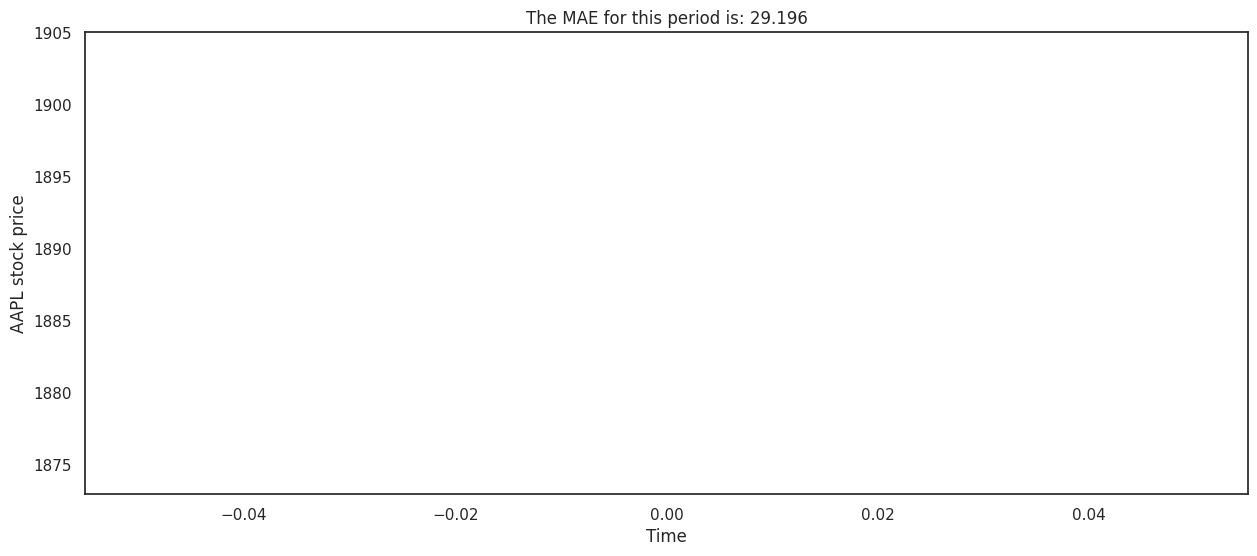

In [ ]:
mae, xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

<Figure size 1600x1600 with 0 Axes>

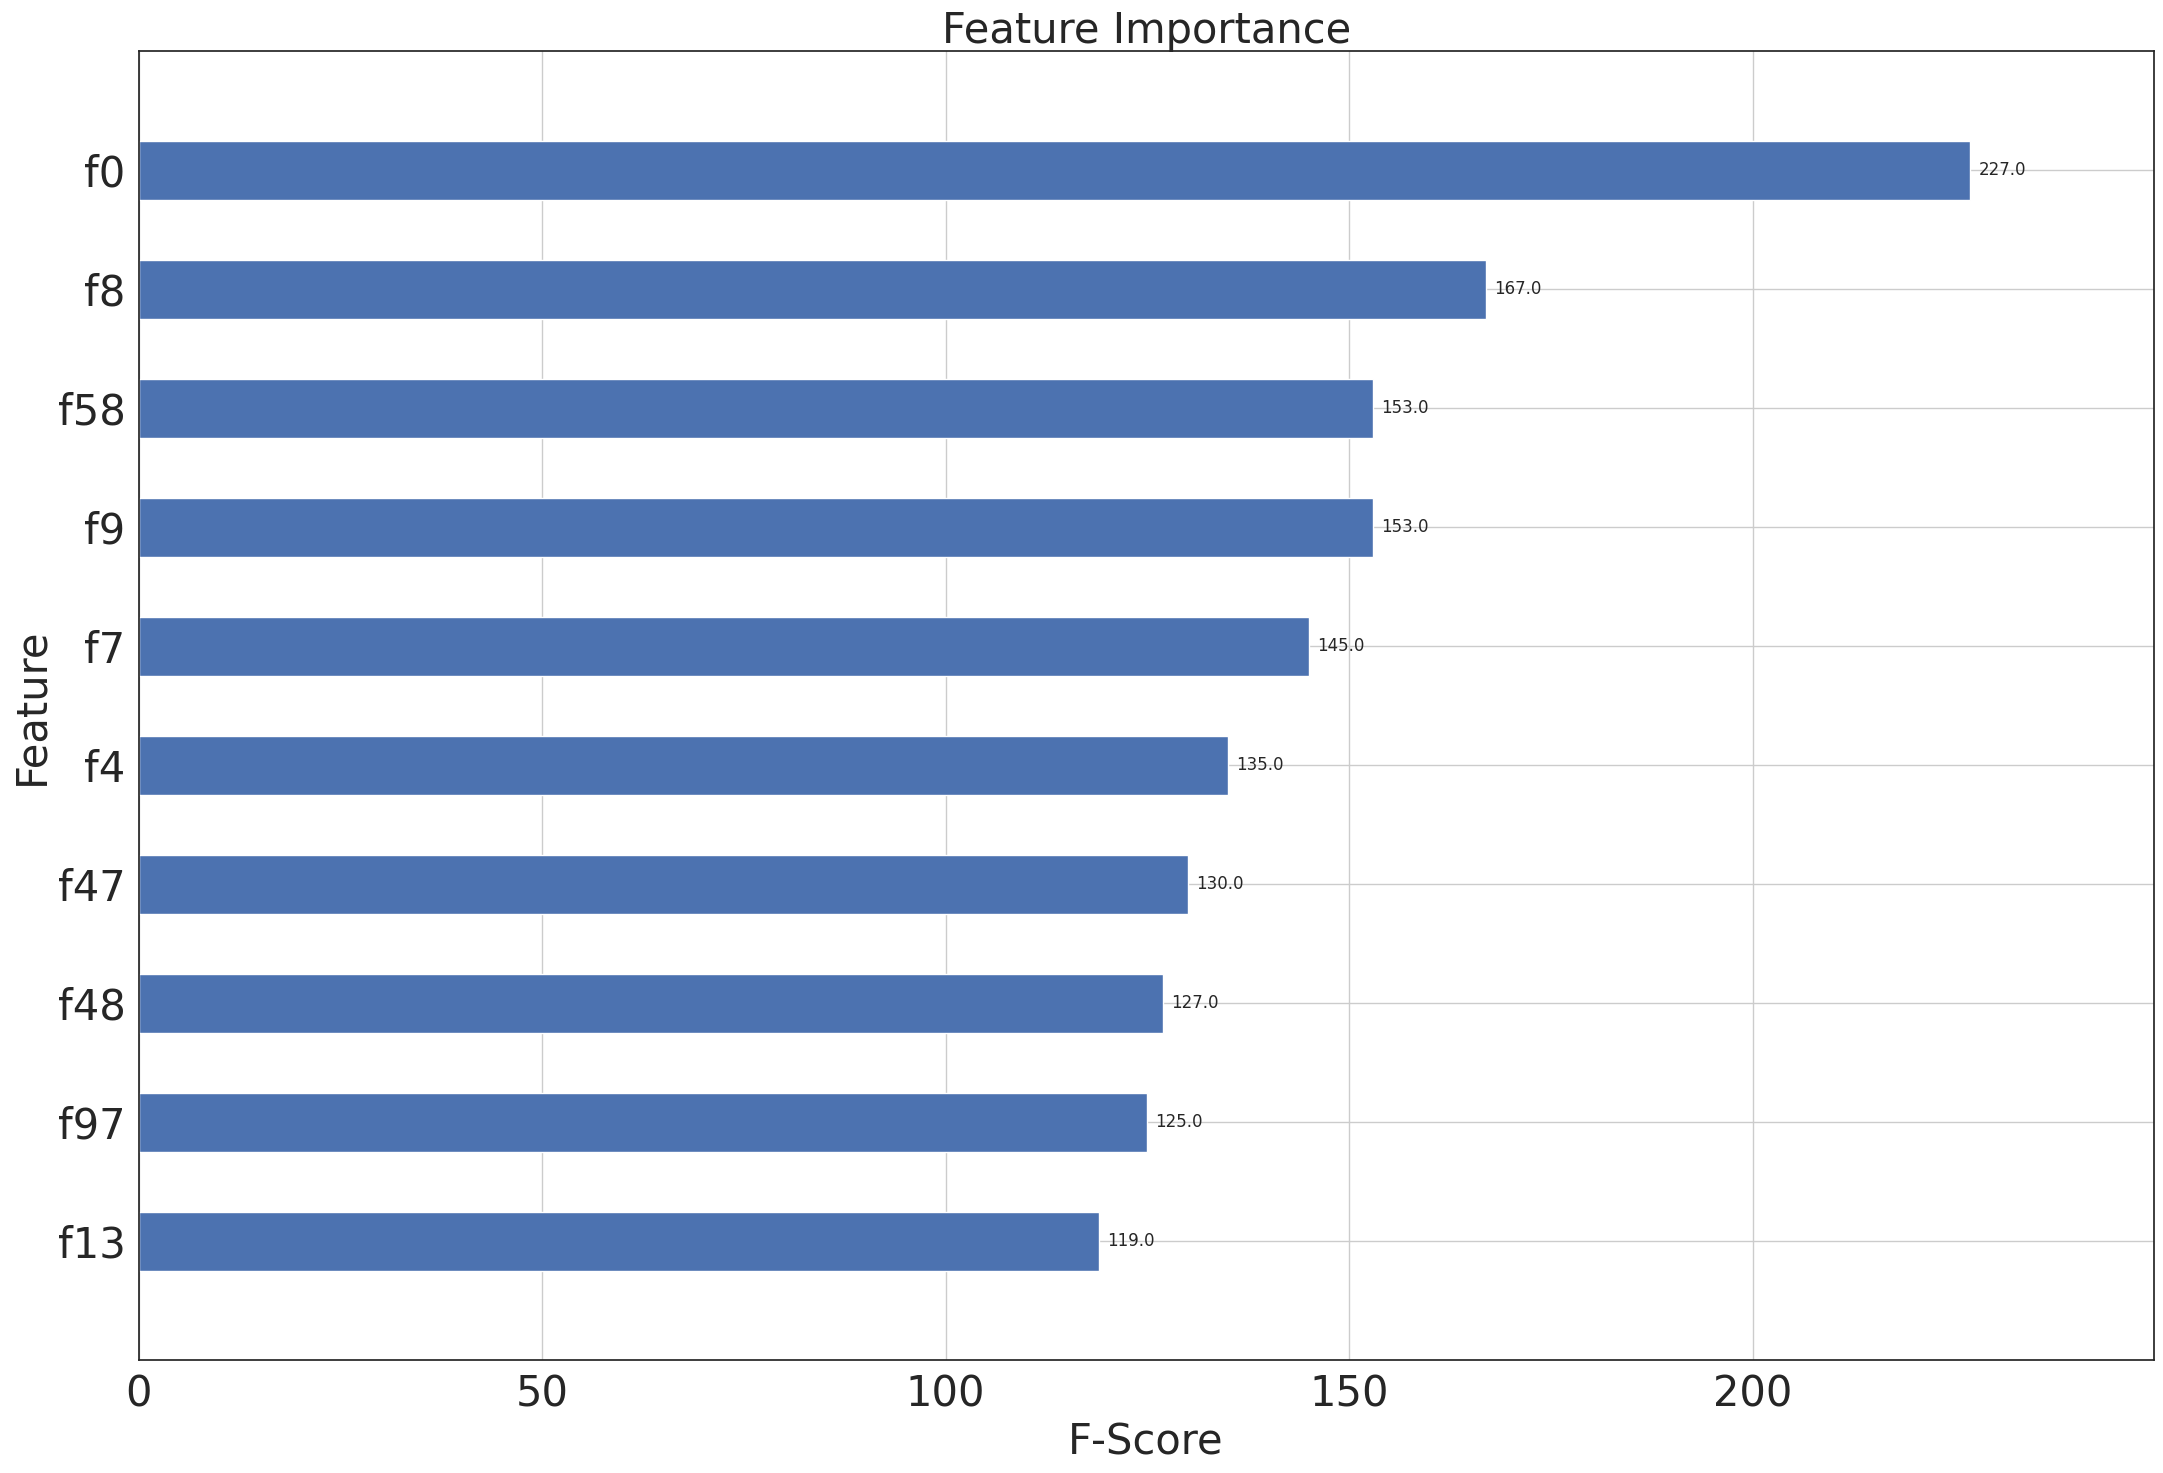

In [ ]:
plt.figure(figsize=(16, 16))
fig, ax = plt.subplots(1, 1, figsize=(26, 17))

plot_importance(xgb_model,ax=ax,height=0.5, max_num_features=10)
ax.set_title("Feature Importance", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Feature", size=30)
plt.xlabel("F-Score", size=30)
plt.show()

In [ ]:
#try:
    #y_hat_train = np.expand_dims(xgb_model.predict(X_train), 1)
    #array = np.empty((stock_prices.shape[0]-y_hat_train.shape[0], 1))
    #array[:] = np.nan
    #predictions = np.concatenate((array, y_hat_train))
#except NameError:
    #print("No Model")


#new_stock_prices = feature_engineering(stock_prices, SPY, predictions=predictions)


#train, test = train_test_split(new_stock_prices, WINDOW)

#train_set, validation_set = train_validation_split(train, PERCENTAGE)
#X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

#Reshaping the data
#X_train = np.array(X_train)
#y_train = np.array(y_train)

#X_val = np.array(X_val)
#y_val = np.array(y_val)

#X_train = X_train.reshape(X_train.shape[0], -1)
#X_val = X_val.reshape(X_val.shape[0], -1)


#new_mae, new_xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

#print(new_mae)

In [ ]:
X_test = np.array(test.iloc[:, :-1])
y_test = np.array(test.iloc[:, -1])
X_test = X_test.reshape(1, -1)

print(f"X_test shape: {X_test.shape}")

X_test shape: (1, 98)


In [ ]:
#Apply the xgboost model on the Test Data

pred_test_xgb = xgb_model.predict(X_test)

For used windowed data: 2
Prediction scope for date 2023-04-22 00:00:00 / 1 days
The predicted price is 1833.99$
With a spread of MAE is 29.2



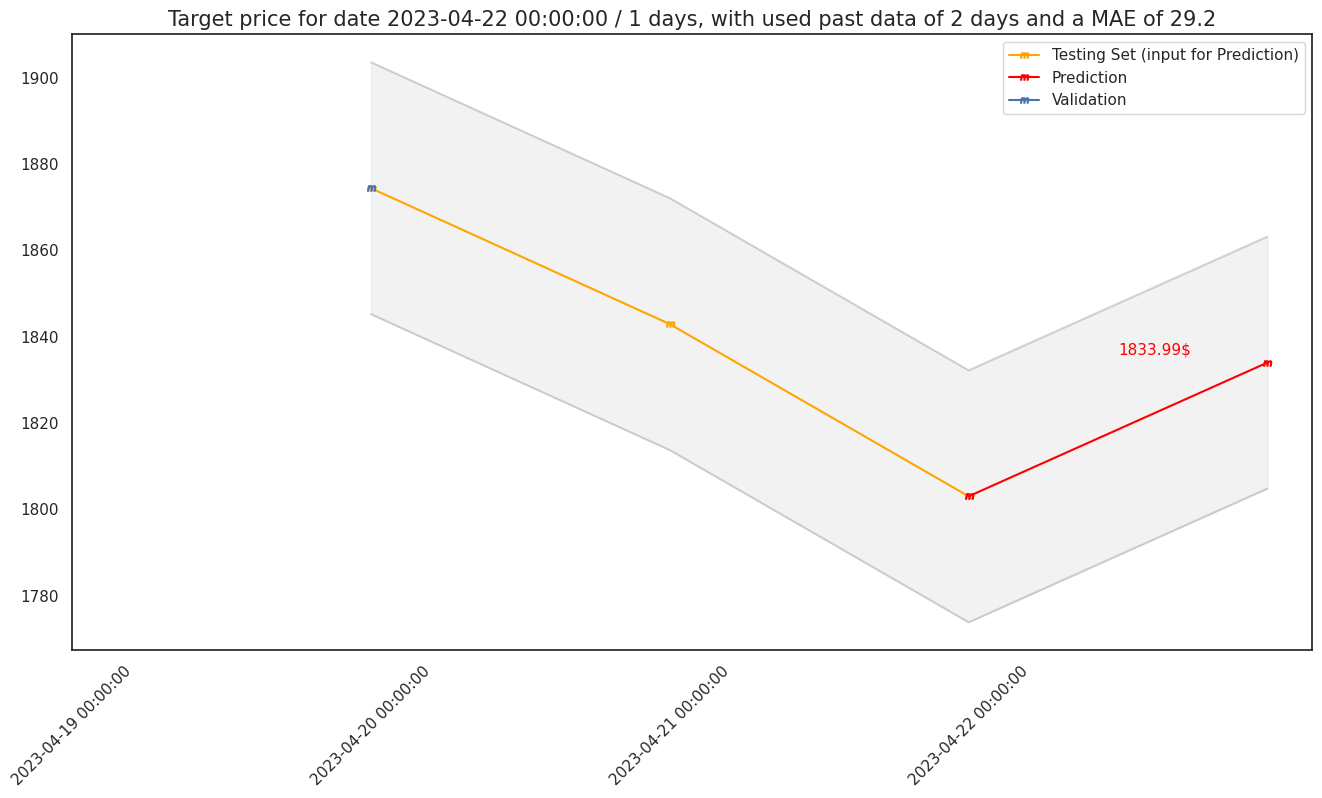


-----------------------------------------------------------------------------



In [ ]:
plotting(y_val, y_test, pred_test_xgb, mae, WINDOW, PREDICTION_SCOPE)

In [ ]:
joblib.dump(xgb_model, "XGBoost.pkl")

['XGBoost.pkl']

In [ ]:
#Parameters for the LSTM
PERCENTAGE = .98 #Split train/val and test set
CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
BATCH_SIZE = 20 #Number of samples that will be propagated through the network. I chose almost a trading month
EPOCH = 50 #Settled to train the model
WINDOW_LSTM = 30 #The window used for the input data
PREDICTION_SCOPE = 0 #How many period to predict, being 0=1

In [ ]:
train_lstm, test_lstm = train_test_split(stock_prices, WINDOW_LSTM)
train_split_lstm, validation_split_lstm = train_validation_split(train_lstm, PERCENTAGE)

train_split_lstm = np.array(train_split_lstm)
validation_split_lstm = np.array(validation_split_lstm)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_split_lstm)

train_scale_lstm = scaler.transform(train_split_lstm)
val_scale_lstm = scaler.transform(validation_split_lstm)
test_scale_lstm = scaler.transform(test_lstm)

print(train_scale_lstm.shape)
print(val_scale_lstm.shape)
print(test_scale_lstm.shape)

(4880, 50)
(100, 50)
(30, 50)


In [ ]:
X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm = windowing(train_scale_lstm, val_scale_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

In [ ]:
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

X_val_lstm = np.array(X_val_lstm)
y_val_lstm = np.array(y_val_lstm)

X_test_lstm = np.array(test_scale_lstm[:, :-1])
y_test_lstm = np.array(test_scale_lstm[:, -1])

print(X_train_lstm.shape)
print(X_val_lstm.shape)
print(X_test_lstm.shape)

(4850, 30, 49)
(1, 30, 49)
(30, 49)


Epoch 1/50
243/243 [==============================] - 14s 36ms/step - loss: 3.1340e-04 - mae: 0.0131 - val_loss: 0.0080 - val_mae: 0.1266
Epoch 2/50
243/243 [==============================] - 9s 35ms/step - loss: 6.7826e-05 - mae: 0.0075 - val_loss: 0.0082 - val_mae: 0.1278
Epoch 3/50
243/243 [==============================] - 8s 32ms/step - loss: 6.3754e-05 - mae: 0.0073 - val_loss: 0.0014 - val_mae: 0.0529
Epoch 4/50
243/243 [==============================] - 8s 34ms/step - loss: 5.9741e-05 - mae: 0.0066 - val_loss: 0.0028 - val_mae: 0.0746
Epoch 5/50
243/243 [==============================] - 8s 35ms/step - loss: 4.6034e-05 - mae: 0.0059 - val_loss: 0.0011 - val_mae: 0.0475
Epoch 6/50
243/243 [==============================] - 8s 31ms/step - loss: 4.3936e-05 - mae: 0.0054 - val_loss: 0.0025 - val_mae: 0.0713
Epoch 7/50
243/243 [==============================] - 8s 35ms/step - loss: 4.7627e-05 - mae: 0.0056 - val_loss: 9.9044e-04 - val_mae: 0.0445
Epoch 8/50
243/243 [================

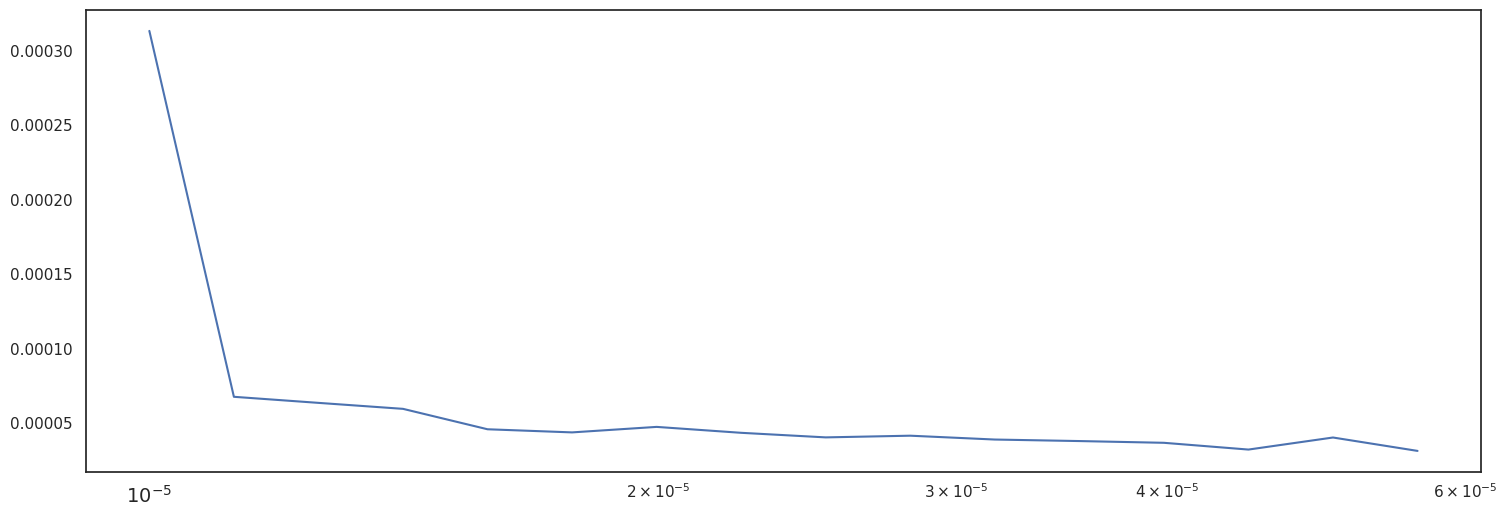

In [ ]:
model_lstm = lstm_model(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, EPOCH, BATCH_SIZE, CALLBACK, plotting=True)

In [ ]:
#Set up predictions for train and validation set
y_hat_lstm = model_lstm.predict(X_val_lstm)
y_hat_train_lstm = model_lstm.predict(X_train_lstm)

#Validation Transormation
mae_lstm = mean_absolute_error(y_hat_lstm, y_hat_lstm)
real_val, pred_val = inverse_transformation(X_val_lstm, y_val_lstm, y_hat_lstm)
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

152/152 [==============================] - 1s 9ms/step


Text(0.5, 1.0, 'MAE for this period: 101.63')

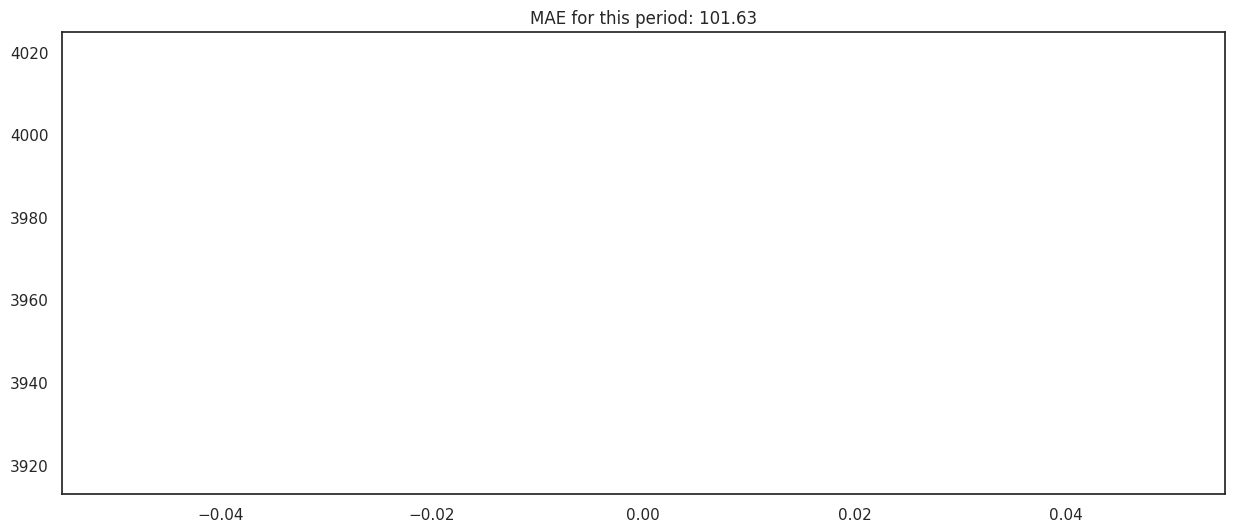

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_val.iloc[:, 49])
plt.plot(pred_val.iloc[:, 49])

plt.title(f"MAE for this period: {round(mae_lstm, 2)}")

In [ ]:
real_train, pred_train = inverse_transformation(X_train_lstm, y_train_lstm, y_hat_train_lstm)

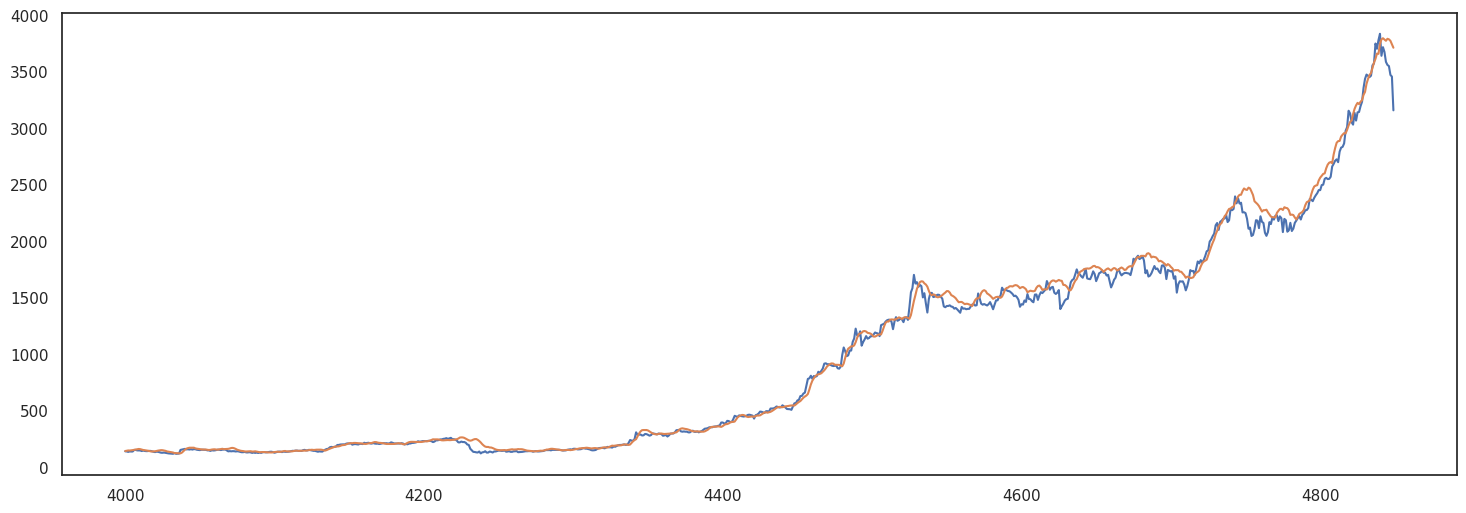

In [ ]:
plt.figure(figsize=(18, 6))

plt.plot(real_train.iloc[4000:, 49])
plt.plot(pred_train.iloc[4000:, 49])

In [ ]:
X_test_formula = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

In [ ]:
X_test_formula.shape

(30, 1, 49)

In [ ]:
X_test_lstm = X_test_formula.reshape(1, X_test_formula.shape[0], X_test_formula.shape[2])

In [ ]:
X_test_lstm.shape

(1, 30, 49)

In [ ]:
y_hat_test_lstm = model_lstm.predict(X_test_lstm)

1/1 [==============================] - 0s 27ms/step


In [ ]:
real_test, pred_test = inverse_transformation(X_test_lstm, y_test_lstm, y_hat_test_lstm)

In [ ]:
y_val_lstm = np.array(real_val.iloc[-30:, 49])
y_test_lstm = np.array(real_test.iloc[:, 49])
pred_test = np.array(pred_test.iloc[-1:, 49])
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

For used windowed data: 30
Prediction scope for date 2023-04-22 00:00:00 / 1 days
The predicted price is 1889.77$
With a spread of MAE is 101.63



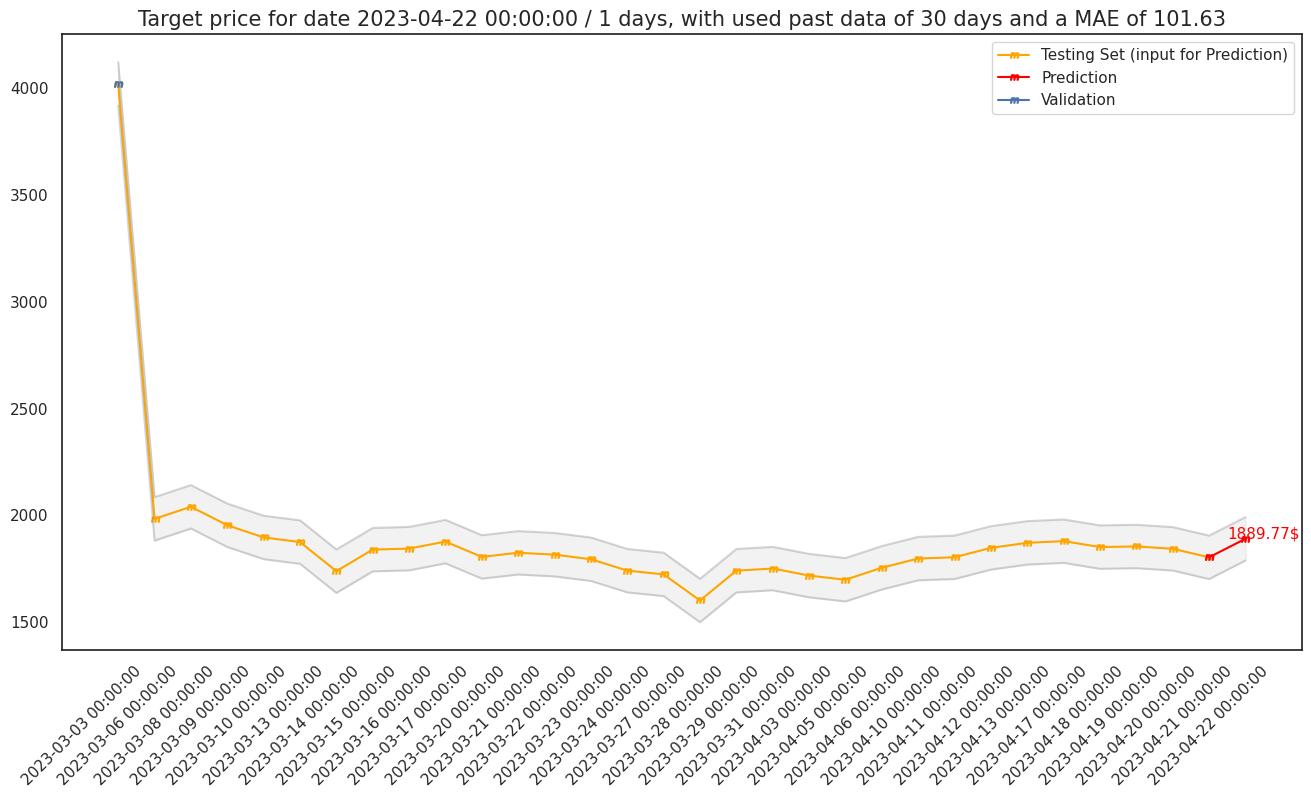


-----------------------------------------------------------------------------



In [ ]:
plotting(y_val_lstm, y_test_lstm, pred_test, mae_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

In [ ]:
#model.save('./SVM')

In [ ]:
#lstm_model = tf.keras.models.load_model("SVM")

In [ ]:
mae_xgboost = mae

In [ ]:
xgboost_model = joblib.load("XGBoost.pkl")

In [ ]:
pred_test

array([1889.76869635])

In [ ]:
pred_test_xgb

array([1833.9935], dtype=float32)

In [ ]:
scope = predictions(mae_lstm, mae_xgboost, pred_test_xgb, pred_test)

In [ ]:
avg_mae = (mae_lstm + mae_xgboost)/2

For used windowed data: 2
Prediction scope for date 2023-04-22 00:00:00 / 1 days
The predicted price is 1846.44$
With a spread of MAE is 65.41



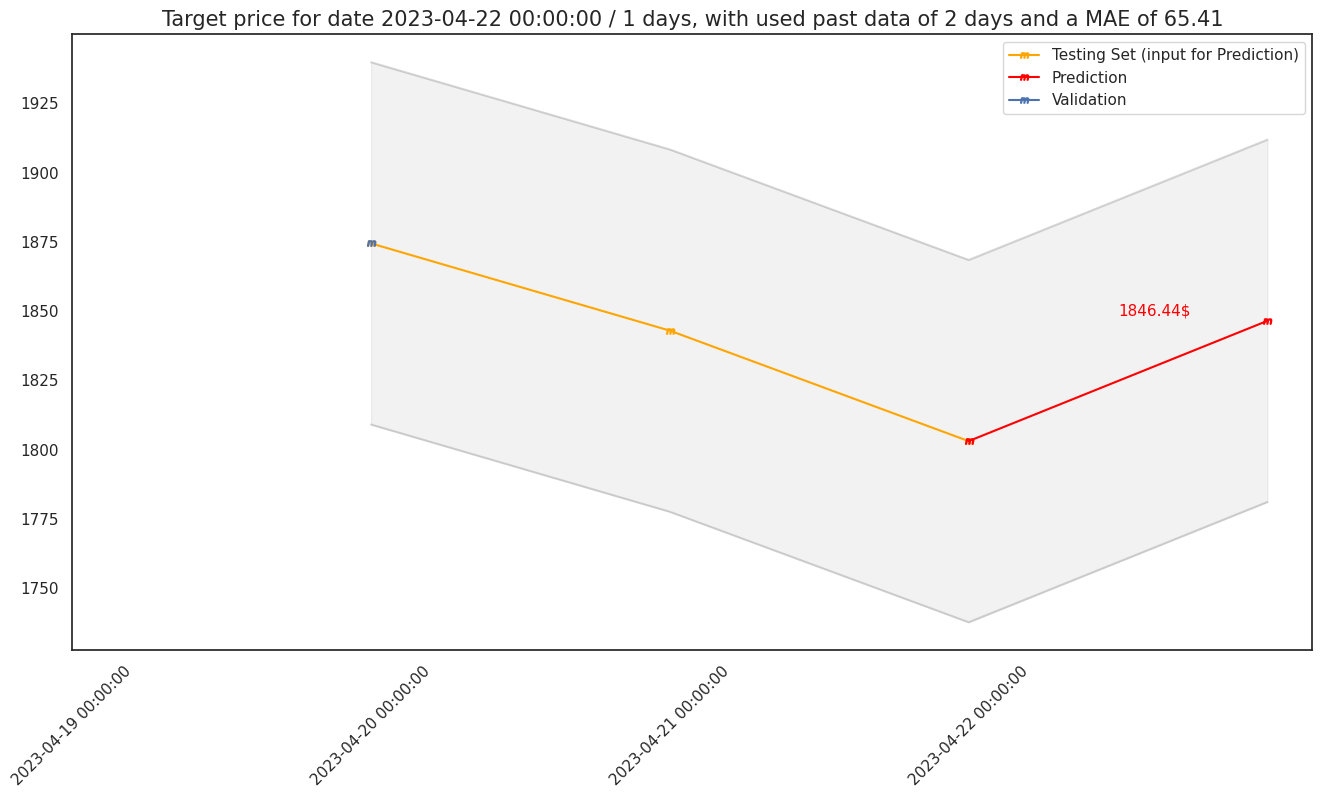


-----------------------------------------------------------------------------



In [ ]:
plotting(y_val, y_test, scope, avg_mae, WINDOW, PREDICTION_SCOPE)